In [87]:
import momepy
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, box, MultiLineString
from shapely.ops import unary_union
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas as dgd
import dask.distributed
import deltalake
import shapely.geometry
import mercantile
import rasterio
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import shape, Polygon, mapping, box, LineString
from rasterio.features import shapes
import osmnx as ox
import os
from tqdm import tqdm

In [88]:
local_crs = 27700
place = "glasgow"
latlng = (-4.251846930489373, 55.86421405612109)
country = "united kingdom"
crs=4326

In [89]:
local_crs = 3414
place = "singapore"
lat = 1.28795311
lng = 103.851784
crs=4326

In [90]:
latlng = (lat, lng)

In [91]:
radius = 35 #km

In [92]:
## create directory ./out/{place} if it does not exist
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        
create_dir(f"./output/{place}")

## part 1: Find limits of cells to download

In [93]:
def create_square(center_point, distance):
    """
    Create a square polygon centered on the given point.
    The 'distance' parameter is half the side length of the square.
    """
    x, y = center_point.x, center_point.y
    return Polygon([(x - distance, y - distance),
                    (x - distance, y + distance),
                    (x + distance, y + distance),
                    (x + distance, y - distance)])

# Create a GeoSeries with the specified point
gdf = gpd.GeoSeries([Point(latlng[1], latlng[0])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((latlng[1] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if latlng[0] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'
    
# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Get the center point in UTM coordinates
center_point = gdf_utm[0]

# Create a square polygon centered on the point
square = create_square(center_point, radius * 1000)  # Convert km to meters

# Create a GeoSeries for the square in UTM coordinates
square_gs_utm = gpd.GeoSeries([square], crs=gdf_utm.crs)

# Reproject the square back to the original CRS
area_of_interest = square_gs_utm.to_crs(crs)

# Plotting
area_of_interest.explore()

/home/virgilxw/miniconda3/envs/morph_model_v1/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


In [94]:
# # Create a GeoDataFrame with the specified point
# gdf = gpd.GeoDataFrame(geometry=[Point(latlng[0], latlng[1])], crs=crs)

# # Reproject to a coordinate system that uses meters (UTM)
# gdf_utm = gdf.to_crs(epsg=local_crs)

# # Create a 50 km buffer around the point
# buffer = gdf_utm.buffer(10000)  # 50 km buffer

# # Reproject buffer back to original CRS
# area_of_interest = buffer.to_crs(epsg=crs)

# # Plottin
# area_of_interest.explore()



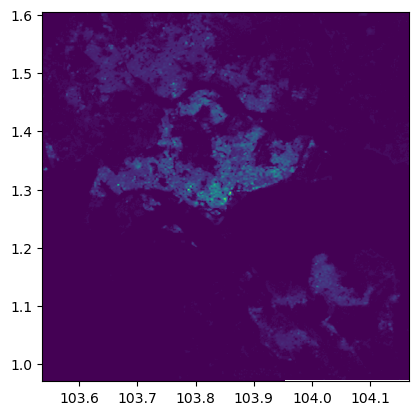

In [95]:
# Read only the portion of the GeoTIFF that intersects with the AOI

cell_polygons = []
with rasterio.open("output/built_height.tif") as src:
    # Calculate the window to read based on AOI bounds
    out_image, transformed = rasterio.mask.mask(src, area_of_interest, crop=True, filled=True)
    out_profile = src.profile.copy()
    
out_profile.update({'width': out_image.shape[2],'height': out_image.shape[1], 'transform': transformed})
with rasterio.open(f"output/{place}.tif", 'w', **out_profile) as dst:
    dst.write(out_image)
    
with rasterio.open(f"output/{place}.tif") as src:
    show(src)

In [96]:
def get_cell_polygon(x, y, transform):
    """
    Create a polygon for the given cell coordinates (x, y) using the affine transform.
    """
    tl = transform * (x, y)
    tr = transform * (x + 1, y)
    br = transform * (x + 1, y + 1)
    bl = transform * (x, y + 1)
    return Polygon([tl, tr, br, bl, tl])

In [97]:
mask = None
with rasterio.Env():
    with rasterio.open(f"output/{place}.tif") as src:
        image = src.read(1) # first band
        transform = src.transform

        # Prepare schema for shapefile
        schema = {
            'properties': [('raster_val', 'int')],
            'geometry': 'Polygon'
        }

        # with fiona.open(f"output/{place}/height_cells.shp", 'w', 
        #                 driver='ESRI Shapefile',
        #                 crs=src.crs,
        #                 schema=schema) as dst:
            
        #     # Iterate over each pixel in the raster
        #     for row in tqdm(range(image.shape[0])):
        #         for col in range(image.shape[1]):
        #             value = image[row, col]
        #             polygon = get_cell_polygon(col, row, transform)
        #             dst.write({
        #                 'properties': {'raster_val': int(value)},
        #                 'geometry': mapping(polygon)
        #             })
        
        # List to hold each feature
        features = []

        # Iterate over each pixel in the raster
        for row in tqdm(range(image.shape[0])):
            for col in range(image.shape[1]):
                value = image[row, col]
                polygon = get_cell_polygon(col, row, transform)
                features.append({
                    'properties': {'raster_val': int(value)},
                    'geometry': polygon
                })

        # Create a GeoDataFrame
        area_of_interest = gpd.GeoDataFrame([f['properties'] for f in features],
                            geometry=[f['geometry'] for f in features],
                            crs=src.crs)
        
        area_of_interest.to_parquet(f"output/{place}/height_cells.shp")


  4%|▍         | 24/637 [00:00<00:08, 69.79it/s]

100%|██████████| 637/637 [00:14<00:00, 44.23it/s]


# part 2: create a buffer that is slightly larger to account for edge effects and download all building footprints + street data

In [98]:
# Get bounds
minx, miny, maxx, maxy = area_of_interest.total_bounds
min_dist = min([abs(minx-latlng[0]), abs(miny-latlng[1]), abs(maxx-latlng[0]), abs(maxy-latlng[1])])

# Create a GeoDataFrame with the specified point
gdf = gpd.GeoDataFrame(geometry=[Point(latlng[1], latlng[0])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((latlng[1] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if latlng[0] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'

# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Create a 50 km buffer around the point
buffer_circle = gdf_utm.buffer((radius+5) * 1000)  # Convert km to meters

buffer = buffer_circle

# Reproject buffer back to original CRS
buffer = buffer.to_crs(crs)

# Plotting
buffer.explore()


/home/virgilxw/miniconda3/envs/morph_model_v1/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


In [99]:
# # This creates a boolean mask where each element is True if the geometry in `gdf` is within any geometry in `area_of_interest`
# mask = area_of_interest.geometry.apply(lambda geom: any(geom.within(aoi_geom) for aoi_geom in buffer.geometry))

# # Apply the mask to select only the relevant features
# selected_features = area_of_interest[mask]

In [100]:
# selected_features_union = selected_features.unary_union

# selected_features_union = gpd.GeoSeries([selected_features_union]).set_crs(epsg=4326)

In [101]:
# selected_features_union.plot()

In [102]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("ms-buildings")

asset = collection.assets["delta"]

storage_options = {
    "account_name": asset.extra_fields["table:storage_options"]["account_name"],
    "sas_token": asset.extra_fields["table:storage_options"]["credential"],
}
table = deltalake.DeltaTable(asset.href, storage_options=storage_options)

quadkeys = [
    int(mercantile.quadkey(tile))
    for tile in mercantile.tiles(*buffer[0].bounds, zooms=9)
]
quadkeys

uris = table.file_uris([("quadkey", "in", quadkeys)])
uris

df = dgd.read_parquet(uris, storage_options=storage_options)


In [103]:
buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()

/tmp/ipykernel_956/1505170059.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()


In [104]:
world_poly = gpd.read_file(f"input/{place}_study_area.shp")

In [105]:
water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})
water_gdf = water_gdf[water_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

/tmp/ipykernel_956/2221155826.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})


In [106]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in water_gdf.columns if col != 'geometry']

# Drop these columns
water_gdf = water_gdf.drop(columns=columns_to_drop)

In [107]:
buffer = gpd.GeoDataFrame(geometry=buffer)

In [108]:
water_gdf = water_gdf.reset_index(drop=True)

In [109]:
buffer = world_poly.overlay(buffer, how='intersection').overlay(water_gdf, how='difference')

<Axes: >

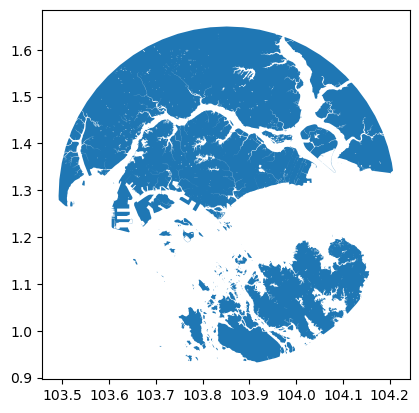

In [110]:
buffer.plot()

In [111]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in buffer.columns if col != 'geometry']

# Drop these columns
buffer = buffer.drop(columns=columns_to_drop)

In [112]:
buffer_new = buffer.dissolve()

In [113]:
buffer_new.to_parquet(f"./output/{place}/study_area.pq")

<Axes: >

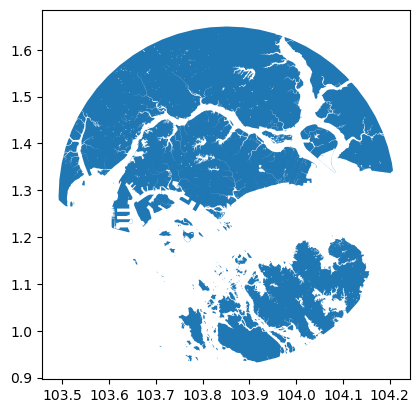

In [114]:
buffer_new.plot()

<Axes: >

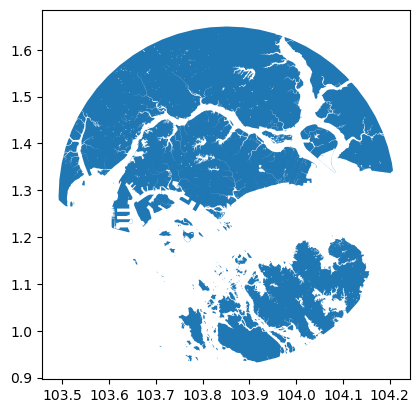

In [115]:
buffer_new.plot()

In [116]:
osm_graph= ox.graph.graph_from_place("batam", network_type='drive')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
streets = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

In [117]:
osm_graph= ox.graph.graph_from_polygon(buffer_new.geometry[0], network_type='drive', truncate_by_edge=True, retain_all=True)
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
streets = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

streets.head()

osmid  oneway   lanes  \
u         v         key                                                      
26782230  246810673 0    [633335608, 747311785, 747311784]    True  [5, 4]   
          26782342  0                [633369736, 74735246]    True       5   
          249766698 0                            477930085    True       4   
          246801953 0                            459186768    True       4   
246810673 246810545 0                             74735245    True       4   

                                 name    highway maxspeed reversed   length  \
u         v         key                                                       
26782230  246810673 0    Cecil Street  secondary       50    False  104.341   
          26782342  0    Cross Street    primary       50    False  124.685   
          249766698 0    Cross Street    primary       50    False   90.361   
          246801953 0    Cecil Street  secondary       50    False  102.741   
246810673 246810545 0    Cecil Street  secondary       50    False   50.764   

                                                                  geometry  \
u         v         key                                                      
26782230  246810673 0    LINESTRING (29803.553 29346.348, 29806.191 293...   
          26782342  0    LINESTRING (29803.553 29346.348, 29752.882 293...   
          249766698 0    LINESTRING (29882.159 29301.875, 29803.553 293...   
          246801953 0    LINESTRING (29751.046 29258.496, 29753.450 292...   
246810673 246810545 0    LINESTRING (29861.658 29432.552, 29875.013 294...   

                              from         to bridge tunnel  ref access  \
u         v         key                                                   
26782230  246810673 0     26782230  246810673    NaN    NaN  NaN    NaN   
          26782342  0     26782230   26782342    NaN    NaN  NaN    NaN   
          249766698 0    249766698   26782230    NaN    NaN  NaN    NaN   
          246801953 0    246801953   26782230    NaN    NaN  NaN    NaN   
246810673 246810545 0    246810673  246810545    NaN    NaN  NaN    NaN   

                        junction width area  
u         v         key                      
26782230  246810673 0        NaN   NaN  NaN  
          26782342  0        NaN   NaN  NaN  
          249766698 0        NaN   NaN  NaN  
          246801953 0        NaN   NaN  NaN  
246810673 246810545 0        NaN   NaN  NaN

<Axes: >

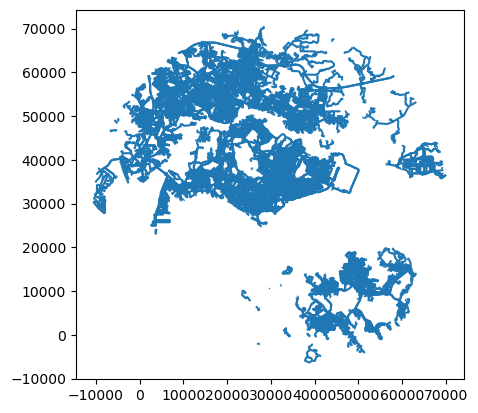

In [118]:
streets.plot()

In [119]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in streets.columns if col != 'geometry']

# Drop these columns
streets = streets.drop(columns=columns_to_drop)

In [120]:
# Assuming your GeoDataFrame is named 'gdf'
line_strings = []
for geometry in streets.geometry:
    if geometry.geom_type == 'LineString':
        line_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        line_strings.extend(list(geometry))

In [121]:
collection = shapely.GeometryCollection(line_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
streets_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

In [122]:
# Assuming streets is your existing GeoDataFrame

# Function to break apart MultiLineStrings
def explode_multilinestring(multilinestring):
    if isinstance(multilinestring, MultiLineString):
        return list(multilinestring)
    else:
        return [multilinestring]

# Explode all MultiLineStrings into individual LineStrings
exploded_lines = [explode_multilinestring(geom) for geom in streets.geometry]

# Flatten the list of lists into a single list of geometries
flat_list = [item for sublist in exploded_lines for item in sublist]

# Create a new GeoDataFrame
streets_noded_gdf = gpd.GeoDataFrame(geometry=flat_list)

<Axes: >

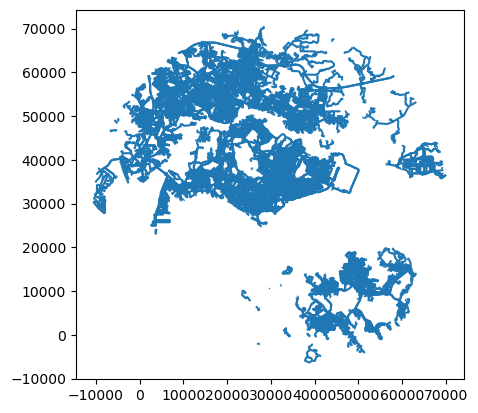

In [123]:
streets_noded_gdf.plot()

In [124]:
streets_noded_gdf = streets_noded_gdf.set_crs(local_crs)

In [125]:
osm_graph= ox.graph.graph_from_polygon(buffer_new.geometry[0], network_type='all', custom_filter='["railway"~"rail"]["tunnel"!="yes"]')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
rail = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

rail.head()



osmid bridge  oneway  reversed   length  \
u          v          key                                                
2274921472 2274921463 0    173144830    yes   False     False  120.815   
           2274921471 0    218220551    yes   False     False   38.564   
           2274921808 0    173144830    yes   False      True  568.615   
2274921463 2274921469 0    218220545    yes   False     False   32.475   
           2274921530 0    173144830    yes   False     False  751.885   

                                 from          to  \
u          v          key                           
2274921472 2274921463 0    2274921463  2274921472   
           2274921471 0    2274921471  2274921472   
           2274921808 0    2274921808  2274921472   
2274921463 2274921469 0    2274921469  2274921463   
           2274921530 0    2274921530  2274921463   

                                                                    geometry  \
u          v          key                                                      
2274921472 2274921463 0    LINESTRING (34221.552 41014.155, 34119.857 410...   
           2274921471 0    LINESTRING (34155.536 41064.543, 34119.857 410...   
           2274921808 0    LINESTRING (33639.657 41382.545, 33738.871 413...   
2274921463 2274921469 0    LINESTRING (34198.104 41036.524, 34221.552 410...   
           2274921530 0    LINESTRING (34802.444 41188.812, 34799.541 411...   

                          service  
u          v          key          
2274921472 2274921463 0       NaN  
           2274921471 0       NaN  
           2274921808 0       NaN  
2274921463 2274921469 0       NaN  
           2274921530 0       NaN

In [126]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in rail.columns if col != 'geometry']

# Drop these columns
rail = rail.drop(columns=columns_to_drop).reset_index(drop=True)

In [127]:
# Assuming your GeoDataFrame is named 'gdf'
rail_strings = []
for geometry in rail.geometry:
    if geometry.geom_type == 'LineString':
        rail_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        rail_strings.extend(list(geometry))

In [128]:
collection = shapely.GeometryCollection(rail_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
rail_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

<Axes: >

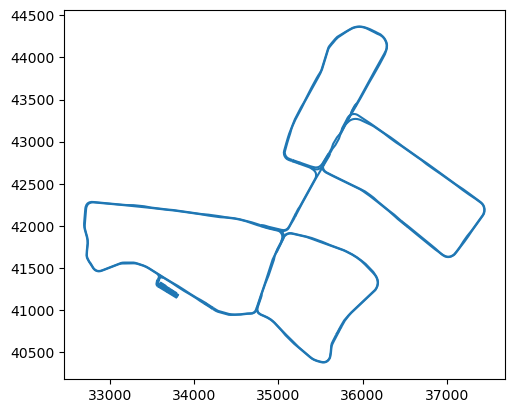

In [129]:
rail_noded_gdf.plot()

In [130]:
buildings

,geometry,meanHeight,RegionName,quadkey,index_right
0,"POLYGON ((104.03485 1.51215, 104.03486 1.51220...",-1.0,Asia,132232213,0
1,"POLYGON ((104.02860 1.54100, 104.02849 1.54103...",-1.0,Asia,132232213,0
2,"POLYGON ((103.89411 1.43515, 103.89405 1.43516...",-1.0,Asia,132232213,0
3,"POLYGON ((103.86660 1.46817, 103.86667 1.46812...",-1.0,Asia,132232213,0
4,"POLYGON ((103.67472 1.43732, 103.67477 1.43728...",-1.0,Asia,132232213,0
...,...,...,...,...,...
76,"POLYGON ((104.07336 1.39878, 104.07341 1.39876...",-1.0,Singapore,132232320,0
77,"POLYGON ((104.07573 1.36921, 104.07569 1.36922...",-1.0,Singapore,132232320,0
78,"POLYGON ((104.07454 1.39951, 104.07454 1.39952...",-1.0,Singapore,132232320,0
79,"POLYGON ((104.07372 1.39953, 104.07378 1.39953...",-1.0,Singapore,132232320,0


In [131]:
buildings = buildings[["geometry"]]

In [132]:
buildings = gpd.sjoin(buildings, buffer_new, how="left", op="within")

/home/virgilxw/miniconda3/envs/morph_model_v1/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [133]:
buildings = buildings[buildings["index_right"] == 0][["geometry"]]

In [134]:
buildings.to_parquet(f"./output/{place}/buildings_raw.pq")

streets_noded_gdf.to_parquet(f"./output/{place}/streets_raw.pq")

rail_noded_gdf.to_parquet(f"./output/{place}/rail_raw.pq")

<Axes: >

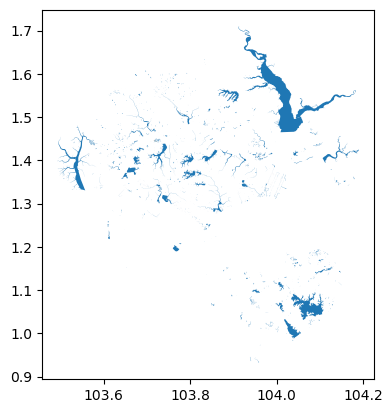

In [135]:
water_gdf.plot()

In [136]:
water_gdf.to_parquet(f"./output/{place}/water.pq")